# Notebook 03: Visualization for Discrete Choice Analysis

**Objective:** Learn basic data visualization in Python (using Matplotlib and Seaborn) and apply it to the mode choice dataset. We will create plots such as mode share bar charts, line plots (e.g., trends or binned relationships), and boxplots to examine distributions of attributes by mode. Each plot will be accompanied by interpretation of what it reveals about traveler behavior or the data structure.

Visualizing data helps us communicate insights and detect patterns (or anomalies) that might not be obvious from tables. For choice modeling, plotting can reveal, for example, how travel time differences influence mode choice or how income distributions vary by chosen mode.

First, let’s set up the plotting libraries:

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: set a style for nicer plots
sns.set_style("whitegrid")


Matplotlib is the foundational plotting library; Seaborn is a higher-level API that works with Pandas and adds aesthetics.

We'll continue using the DataFrame `df` from Notebook 02 (make sure to run those cells or reload the CSV if starting fresh in this notebook).

## 03.1 Bar Chart of Mode Shares

A simple but important plot is a **bar chart of the mode shares** (market share of each alternative). We computed the percentages earlier; now let's visualize them.

In [4]:
import pandas as pd

# Load the mode choice dataset
df = pd.read_csv("../data/raw/apollo_modeChoiceData.csv")
print("Data loaded. Number of rows:", len(df))
df.head(5)  # display the first 5 rows


Data loaded. Number of rows: 8000


,ID,RP,SP,RP_journey,SP_task,av_car,av_bus,av_air,av_rail,time_car,...,access_air,service_air,time_rail,cost_rail,access_rail,service_rail,female,business,income,choice
0,1,1,0,1.0,NaN,0,0,1,1,0,...,55,0,140,55,5,0,0,0,46705,4
1,1,1,0,2.0,NaN,0,0,1,1,0,...,45,0,170,45,20,0,0,0,46705,4
2,1,0,1,NaN,1.0,0,0,1,1,0,...,55,3,170,35,5,2,0,0,46705,4
3,1,0,1,NaN,2.0,0,0,1,1,0,...,45,1,120,75,5,3,0,0,46705,4
4,1,0,1,NaN,3.0,0,0,1,1,0,...,40,1,155,75,25,2,0,0,46705,4


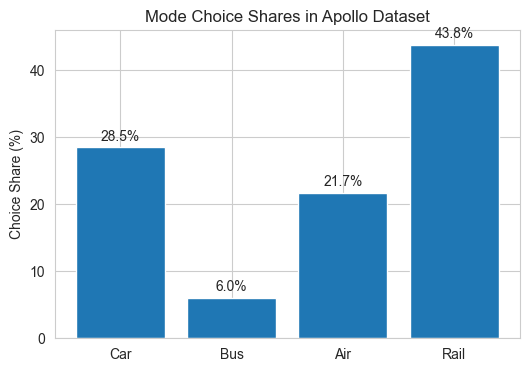

In [5]:
# Calculate mode shares (%)
mode_counts = df["choice"].value_counts().sort_index()
mode_labels = ["Car", "Bus", "Air", "Rail"]  # 1=Car,2=Bus,3=Air,4=Rail
mode_shares = mode_counts / len(df) * 100

# Plot
plt.figure(figsize=(6,4))
plt.bar(mode_labels, mode_shares)
plt.ylabel("Choice Share (%)")
plt.title("Mode Choice Shares in Apollo Dataset")
for i, v in enumerate(mode_shares):
    plt.text(i, v+1, f"{v:.1f}%", ha='center')  # annotate percentages
plt.show()

This bar chart will show four bars for Car, Bus, Air, Rail with their respective percentages labeled on top. The visualization makes it clear which modes dominate.

For an analyst, this plot confirms the overall mode popularity. For instance, we saw a surprisingly low share for bus, we might ask if the bus options in the survey were particularly unattractive (long journey times or poor service). Conversely, a high air share could indicate many long-distance trips in the data.

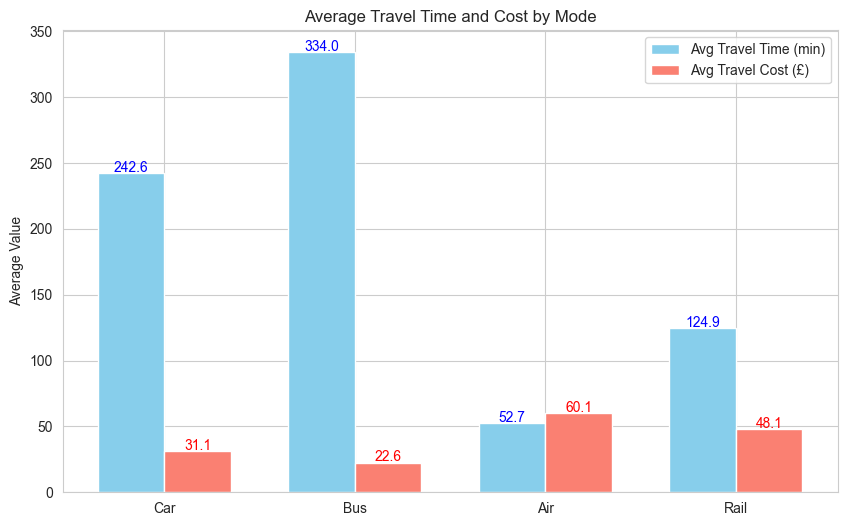

In [6]:
# Calculate average travel time and cost by mode
avg_time = {
    "Car": df["time_car"].mean(),
    "Bus": df["time_bus"].mean(),
    "Air": df["time_air"].mean(),
    "Rail": df["time_rail"].mean()
}
avg_cost = {
    "Car": df["cost_car"].mean(),
    "Bus": df["cost_bus"].mean(),
    "Air": df["cost_air"].mean(),
    "Rail": df["cost_rail"].mean()
}
modes = list(avg_time.keys())
time_values = list(avg_time.values())
cost_values = list(avg_cost.values())   
x = range(len(modes))
width = 0.35  # width of the bars
# Plot average travel time and cost side by side
plt.figure(figsize=(10,6))
plt.bar(x, time_values, width=width, label='Avg Travel Time (min)', color='skyblue')
plt.bar([p + width for p in x], cost_values, width=width, label='Avg Travel Cost (£)', color='salmon')
plt.xticks([p + width/2 for p in x], modes)
plt.ylabel("Average Value")
plt.title("Average Travel Time and Cost by Mode")
plt.legend()
for i in range(len(modes)):
    plt.text(i, time_values[i]+1, f"{time_values[i]:.1f}", ha='center', color='blue')
    plt.text(i + width, cost_values[i]+1, f"{cost_values[i]:.1f}", ha='center', color='red')
plt.show()  

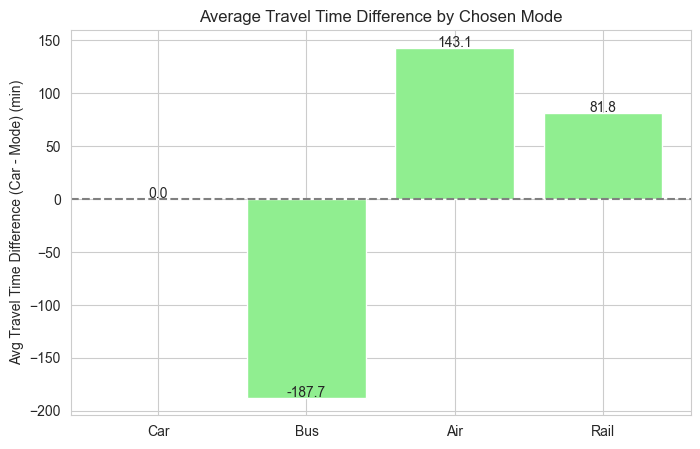

In [7]:
# Calculate average travel time difference (car - other modes) by chosen mode
df["time_diff_car_bus"] = df["time_car"] - df["time_bus"]
df["time_diff_car_air"] = df["time_car"] - df["time_air"]
df["time_diff_car_rail"] = df["time_car"] - df["time_rail"]     
avg_time_diff = {
    "Car": 0,  # baseline
    "Bus": df[df["choice"] == 2]["time_diff_car_bus"].mean(),
    "Air": df[df["choice"] == 3]["time_diff_car_air"].mean(),
    "Rail": df[df["choice"] == 4]["time_diff_car_rail"].mean()
}
modes = list(avg_time_diff.keys())
time_diff_values = list(avg_time_diff.values())
# Plot average travel time difference by chosen mode
plt.figure(figsize=(8,5))
plt.bar(modes, time_diff_values, color='lightgreen')
plt.ylabel("Avg Travel Time Difference (Car - Mode) (min)")
plt.title("Average Travel Time Difference by Chosen Mode")
for i, v in enumerate(time_diff_values):
    plt.text(i, v + 1, f"{v:.1f}", ha='center')
plt.axhline(0, color='gray', linestyle='--')
plt.show()  


## 03.2 Binned Line Plot: Travel Time vs Mode Choice Probability

Now, let's create a more analytical plot: how does travel time difference affect mode choice? Specifically, we can examine how often car is chosen relative to an alternative as a function of the difference in travel times. One way is to create bins of, say, (time_car - time_train) and see car’s choice frequency by bin.

For simplicity, let's explore the relationship between car travel time and the probability of choosing car. We can bin car travel times and compute the share of car choices in each bin. This requires considering only observations where car is available; otherwise including unavailable with time 0 would distort results.

/var/folders/m2/kskgzsyn6t9b8xsjgl711fv00000gp/T/ipykernel_6181/2326280374.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_car_avail.groupby("time_car_bins")["choice"]


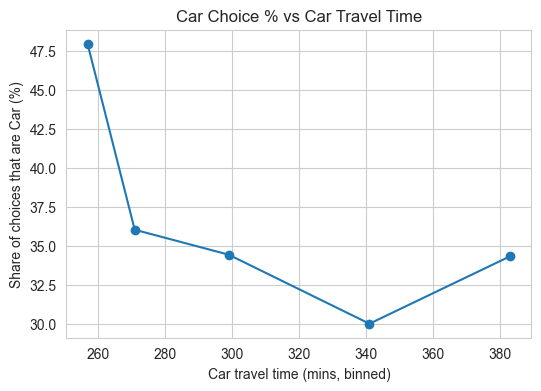

In [8]:
# Filter to observations where car was available (av_car == 1)
# Make an explicit copy to avoid SettingWithCopyWarning
df_car_avail = df.loc[df["av_car"] == 1].copy()

# Create bins for car travel time (10 bins) and assign to the copy
df_car_avail["time_car_bins"] = pd.cut(df_car_avail["time_car"], bins=10)

# Compute car share (%) per bin (will ignore empty bins automatically)
car_share_by_time = (
    df_car_avail.groupby("time_car_bins")["choice"]
    .apply(lambda x: (x == 1).mean() * 100)
)

# If index entries are Interval objects, take midpoints directly
bin_midpoints = [interval.mid for interval in car_share_by_time.index]

# Drop any NA bins (just in case) and sort by midpoint for plotting
plot_df = (
    pd.DataFrame({"mid": bin_midpoints, "car_share": car_share_by_time.values})
    .dropna()
    .sort_values("mid")
)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(plot_df["mid"], plot_df["car_share"], marker="o")
plt.xlabel("Car travel time (mins, binned)")
plt.ylabel("Share of choices that are Car (%)")
plt.title("Car Choice % vs Car Travel Time")
plt.grid(True)
plt.show()



As you can see, this produced a line (or stepwise) chart showing how the percentage of trips where car is chosen changes as car travel time increases. We expect a downward trend: when car travel time is low (car is fast), a high proportion of people choose car; as car travel time increases (car trip is longer), fewer choose car (maybe they opt for plane or train if car is very slow).

Interpreting the result: The car travel time < 200 minutes yields ~48% car share, but when car time > 340 minutes, car share drops to ~30%, it indicates travelers switch to other modes for very long trips (likely air or train for long distances). This matches intuition: if driving takes 6 hours, many will prefer a 1-hour flight. If driving takes 2 hours, many stick with driving.

This kind of plot is essentially a revealed preference trend: it visualizes how the utility advantage of car (here inversely via travel time) affects choice. It's a non-parametric glimpse at the effect of travel time on mode choice.

/var/folders/m2/kskgzsyn6t9b8xsjgl711fv00000gp/T/ipykernel_6181/89269938.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_car_avail.groupby("cost_car_bins")["choice"]


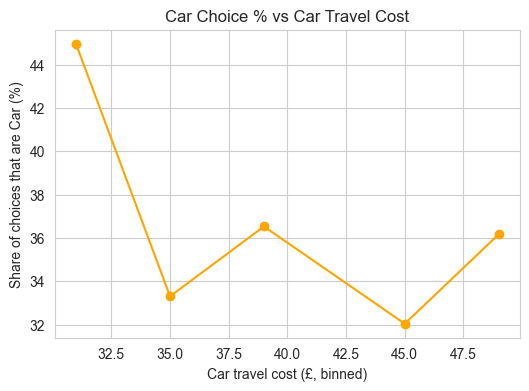

In [9]:
# Binned plot for car cost vs car choice share
df_car_avail["cost_car_bins"] = pd.cut(df_car_avail["cost_car"], bins=10)
car_share_by_cost = (
    df_car_avail.groupby("cost_car_bins")["choice"]
    .apply(lambda x: (x == 1).mean() * 100)
)
# If index entries are Interval objects, take midpoints directly
bin_midpoints_cost = [interval.mid for interval in car_share_by_cost.index]     
# Drop any NA bins (just in case) and sort by midpoint for plotting
plot_df_cost = (
    pd.DataFrame({"mid": bin_midpoints_cost, "car_share": car_share_by_cost.values})
    .dropna()
    .sort_values("mid")
)       
# Plot
plt.figure(figsize=(6, 4))
plt.plot(plot_df_cost["mid"], plot_df_cost["car_share"], marker="o", color='orange')
plt.xlabel("Car travel cost (£, binned)")
plt.ylabel("Share of choices that are Car (%)")
plt.title("Car Choice % vs Car Travel Cost")
plt.grid(True)
plt.show()



/var/folders/m2/kskgzsyn6t9b8xsjgl711fv00000gp/T/ipykernel_6181/1623103964.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mode_avail.groupby(f"{bin_col}_bins")["choice"]


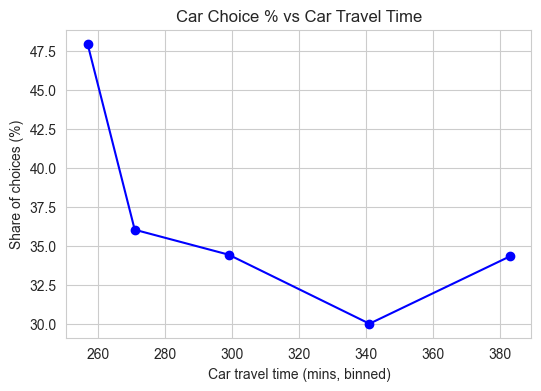

/var/folders/m2/kskgzsyn6t9b8xsjgl711fv00000gp/T/ipykernel_6181/1623103964.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mode_avail.groupby(f"{bin_col}_bins")["choice"]


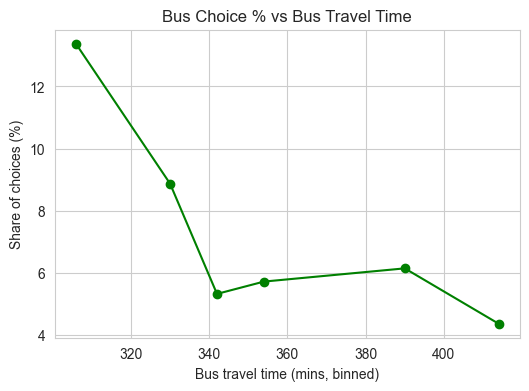

/var/folders/m2/kskgzsyn6t9b8xsjgl711fv00000gp/T/ipykernel_6181/1623103964.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mode_avail.groupby(f"{bin_col}_bins")["choice"]


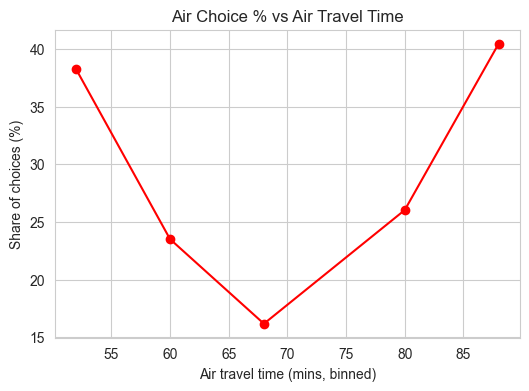

/var/folders/m2/kskgzsyn6t9b8xsjgl711fv00000gp/T/ipykernel_6181/1623103964.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mode_avail.groupby(f"{bin_col}_bins")["choice"]


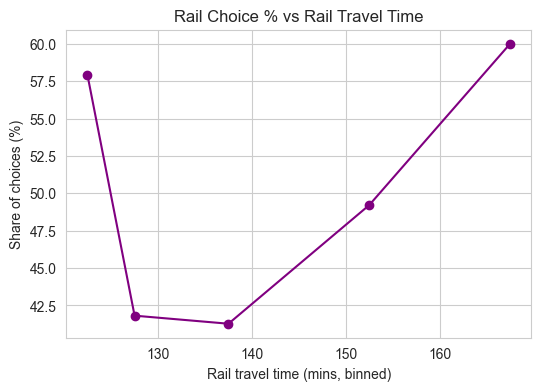

In [10]:
def plot_binned_choice_share(df, mode_col, choice_value, bin_col, bins=10, xlabel="", ylabel="", title="", color='blue'):
    df_mode_avail = df.loc[df[mode_col] == 1].copy()
    df_mode_avail[f"{bin_col}_bins"] = pd.cut(df_mode_avail[bin_col], bins=bins)
    choice_share_by_bin = (
        df_mode_avail.groupby(f"{bin_col}_bins")["choice"]
        .apply(lambda x: (x == choice_value).mean() * 100)
    )
    bin_midpoints = [interval.mid for interval in choice_share_by_bin.index]
    plot_df = (
        pd.DataFrame({"mid": bin_midpoints, "choice_share": choice_share_by_bin.values})
        .dropna()
        .sort_values("mid")
    )
    plt.figure(figsize=(6, 4))
    plt.plot(plot_df["mid"], plot_df["choice_share"], marker="o", color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()  
# Define modes and their attributes for plotting
modes_info = {
    "Car": {"mode_col": "av_car", "choice_value": 1, "bin_col": "time_car", "xlabel": "Car travel time (mins, binned)", "color": "blue"},
    "Bus": {"mode_col": "av_bus", "choice_value": 2, "bin_col": "time_bus", "xlabel": "Bus travel time (mins, binned)", "color": "green"},
    "Air": {"mode_col": "av_air", "choice_value": 3, "bin_col": "time_air", "xlabel": "Air travel time (mins, binned)", "color": "red"},
    "Rail": {"mode_col": "av_rail", "choice_value": 4, "bin_col": "time_rail", "xlabel": "Rail travel time (mins, binned)", "color": "purple"},
}
# Loop through each mode and create plots
for mode, info in modes_info.items():
    plot_binned_choice_share(
        df,
        mode_col=info["mode_col"],
        choice_value=info["choice_value"],
        bin_col=info["bin_col"],
        bins=10,
        xlabel=info["xlabel"],
        ylabel="Share of choices (%)",
        title=f"{mode} Choice % vs {mode} Travel Time",
        color=info["color"]
    )


## 03.3 Boxplots: Distribution of Attributes by Chosen Mode

Boxplots are great to compare distributions across categories. We will create boxplots for key variables, such as travel cost and travel time, grouped by the chosen mode. This helps visualize differences in trip characteristics for each mode.

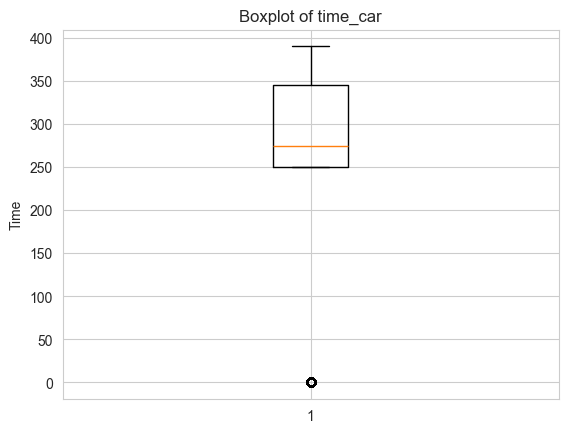

In [32]:
# plot boxplot for time_car using matplotlib

plt.boxplot(df['time_car'])
plt.title('Boxplot of time_car')
plt.ylabel('Time')
plt.show()

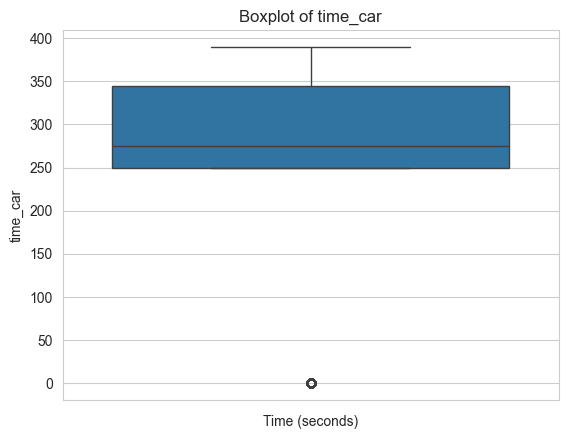

In [33]:
# plot boxplot for time_car using seaborn

sns.boxplot(y=df['time_car'])
plt.title('Boxplot of time_car')
plt.xlabel('Time (seconds)')
plt.show()

Let's now compare the distribution of travel distances or times of trips by mode chosen. The dataset doesn't have distance explicitly, but travel time can serve as a proxy for trip length. We should compare apples to apples: each observation has times for all modes, but let's consider the time of the chosen mode for each trip:

- If someone chose car, use `time_car` for that observation.

- If chose bus, use `time_bus`, etc.

We can construct an array of "chosen travel times" by indexing the DataFrame appropriately, or simpler: split by mode choice and plot each.

Using Seaborn:

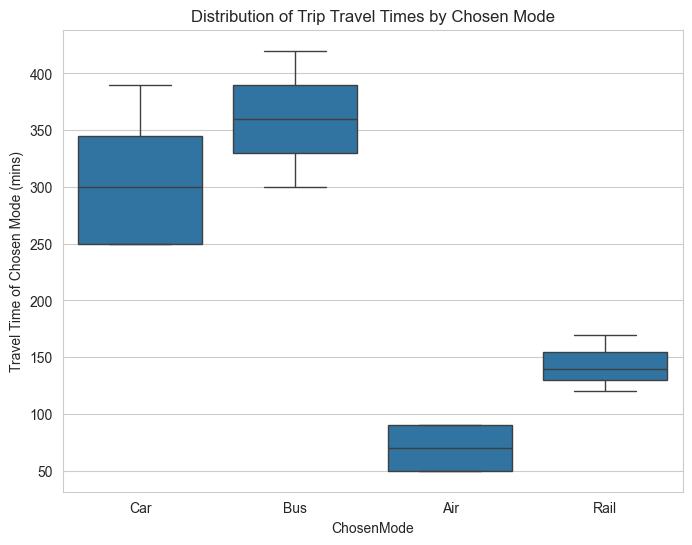

In [34]:
# Prepare data for boxplot: for each mode choice, what was the travel time of that mode?
chosen_times = []
chosen_modes = []
for mode_val, mode_name in zip([1,2,3,4], ["Car","Bus","Air","Rail"]):
    mode_df = df[df["choice"] == mode_val]
    # pick the corresponding time column
    time_col = f"time_{mode_name.lower()}"  # matches time_car, time_bus, etc.
    chosen_times.extend(mode_df[time_col])
    chosen_modes.extend([mode_name]*len(mode_df))

chosen_time_df = pd.DataFrame({"ChosenMode": chosen_modes, "TravelTime": chosen_times})
plt.figure(figsize=(8,6))
sns.boxplot(x="ChosenMode", y="TravelTime", data=chosen_time_df)
plt.ylabel("Travel Time of Chosen Mode (mins)")
plt.title("Distribution of Trip Travel Times by Chosen Mode")
plt.show()


Each boxplot shows the distribution of travel times for trips where that mode was chosen.

Another boxplot idea: cost by mode chosen. People choosing air likely paid higher cost (since air in data has higher fares), bus choosers paid lowest on average. Let's do one more boxplot for cost:

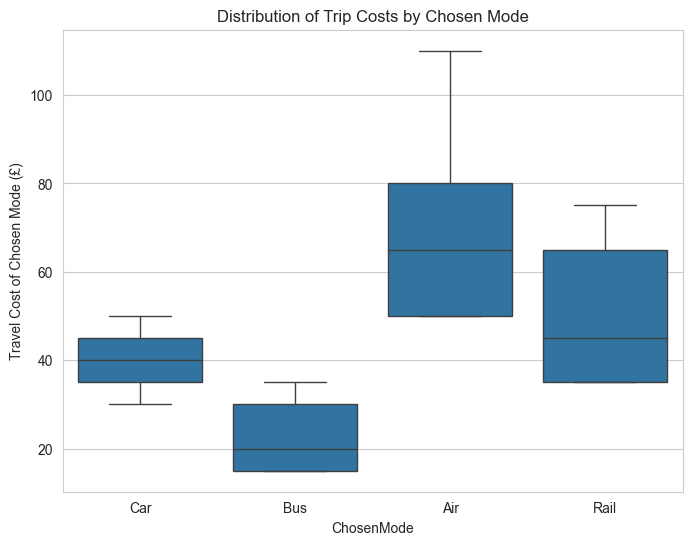

In [35]:
chosen_costs = []
chosen_modes = []
for mode_val, mode_name in zip([1,2,3,4], ["Car","Bus","Air","Rail"]):
    mode_df = df[df["choice"] == mode_val]
    cost_col = f"cost_{mode_name.lower()}"
    chosen_costs.extend(mode_df[cost_col])
    chosen_modes.extend([mode_name]*len(mode_df))

chosen_cost_df = pd.DataFrame({"ChosenMode": chosen_modes, "TravelCost": chosen_costs})
plt.figure(figsize=(8,6))
sns.boxplot(x="ChosenMode", y="TravelCost", data=chosen_cost_df)
plt.ylabel("Travel Cost of Chosen Mode (£)")
plt.title("Distribution of Trip Costs by Chosen Mode")
plt.show()


This shows:

- Air chosen trips have the highest costs (since air tickets were say £50-110 in SP).

- Rail maybe second highest (rail cost up to £75).

- Car costs might include fuel or something (~£40 mean).

- Bus cheapest (maybe ~£25 mean).

Outliers might show some spread due to SP scenarios.

Interpretation: Higher cost modes (air, rail) are only chosen when justified by other factors (like much lower travel time or maybe required for long distance). Lower cost modes (bus) attract cost-sensitive travelers or scenarios where time isn't critical. Car sits in between with moderate cost (fuel) and moderate travel time; it's chosen across a range of cost/time trade-offs.

The boxplot's whiskers and outliers give an idea of variability. For instance, car cost might have a tighter range if fuel cost doesn’t vary hugely per trip (though if distance varies, fuel cost could vary). Air might have more variance if some scenarios set very high or low prices. Noticing these details can hint at how much cost variation each mode had in the experiment.

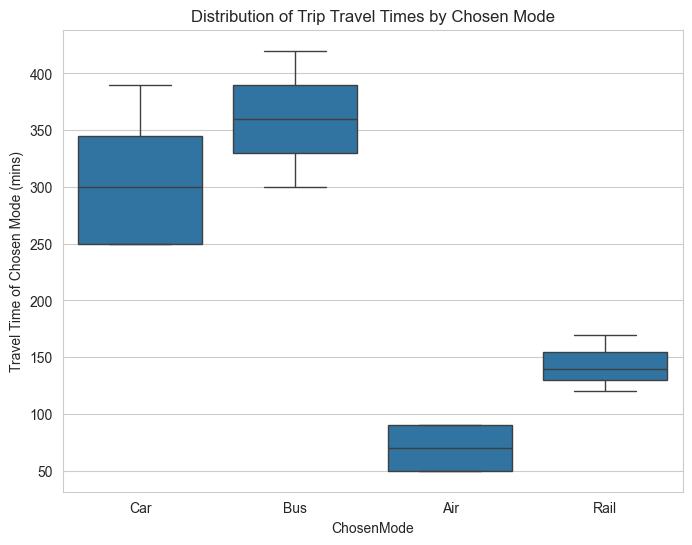

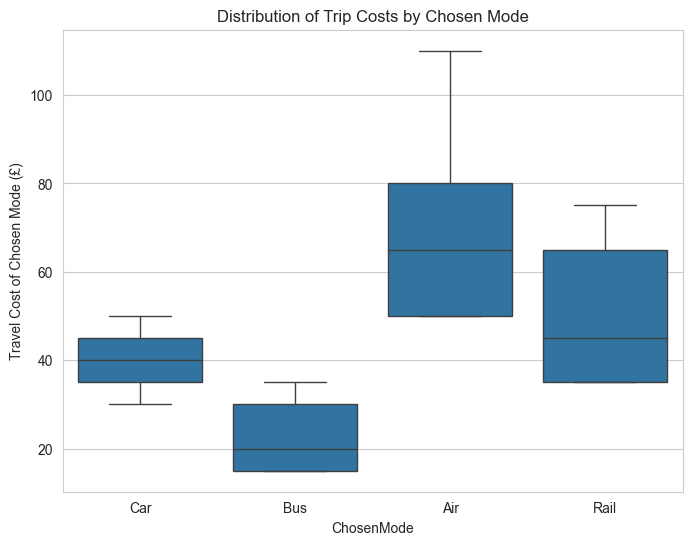

In [36]:
# let's add more advanced boxplots professionally on the data in addition what I did above and use function, numeric dictionary 
def plot_boxplot_by_choice(df, choice_col, value_cols, mode_labels, ylabel, title):
    data = []
    modes = []
    for mode_val, mode_name in zip(range(1, len(mode_labels)+1), mode_labels):
        mode_df = df[df[choice_col] == mode_val]
        value_col = value_cols[mode_name]
        data.extend(mode_df[value_col])
        modes.extend([mode_name]*len(mode_df))
    plot_df = pd.DataFrame({"ChosenMode": modes, "Value": data})
    plt.figure(figsize=(8,6))
    sns.boxplot(x="ChosenMode", y="Value", data=plot_df)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
mode_labels = ["Car", "Bus", "Air", "Rail"]
time_cols = {mode: f"time_{mode.lower()}" for mode in mode_labels}
cost_cols = {mode: f"cost_{mode.lower()}" for mode in mode_labels}
# Plot travel time boxplot
plot_boxplot_by_choice(df, "choice", time_cols, mode_labels, "Travel Time of Chosen Mode (mins)", "Distribution of Trip Travel Times by Chosen Mode")
# Plot travel cost boxplot
plot_boxplot_by_choice(df, "choice", cost_cols, mode_labels, "Travel Cost of Chosen Mode (£)", "Distribution of Trip Costs by Chosen Mode")


## 03.4 Additional Plot: Attitudinal or Demographic

Let's do one quick demographic plot: Mode choice by gender. We can make a stacked bar chart showing % of choices by mode for male vs female:

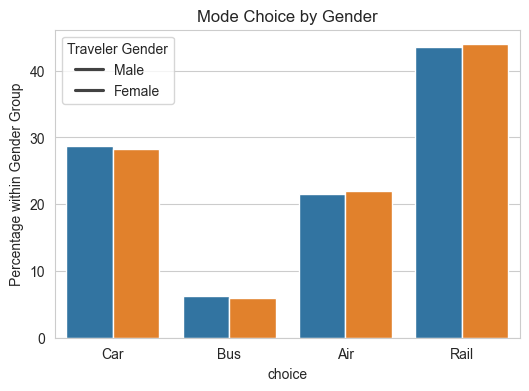

In [37]:
gender_mode = df.groupby("female")["choice"].value_counts(normalize=True).mul(100).rename("percent").reset_index()
# gender_mode will have columns: female (0/1), choice (mode), percent
plt.figure(figsize=(6,4))
sns.barplot(x="choice", y="percent", hue="female", data=gender_mode)
plt.xticks([0,1,2,3], ["Car","Bus","Air","Rail"])
plt.ylabel("Percentage within Gender Group")
plt.title("Mode Choice by Gender")
plt.legend(labels=["Male","Female"], title="Traveler Gender")
plt.show()


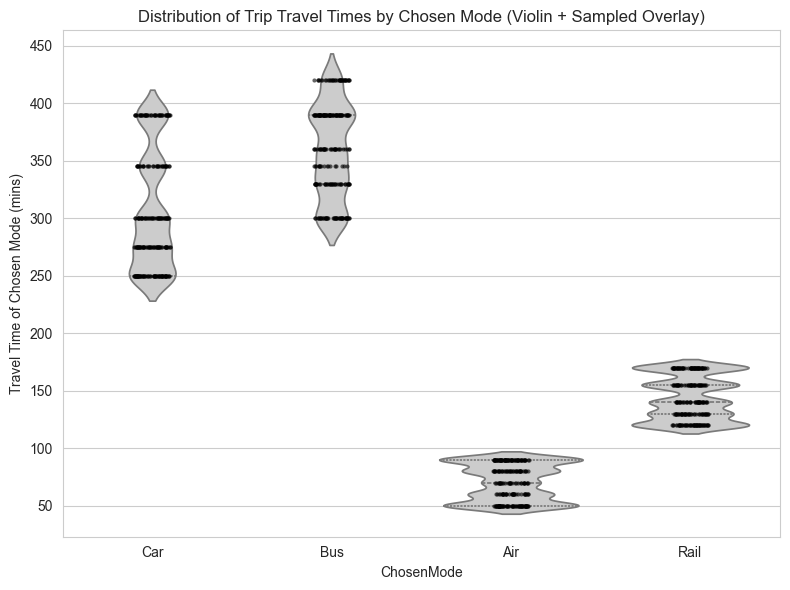

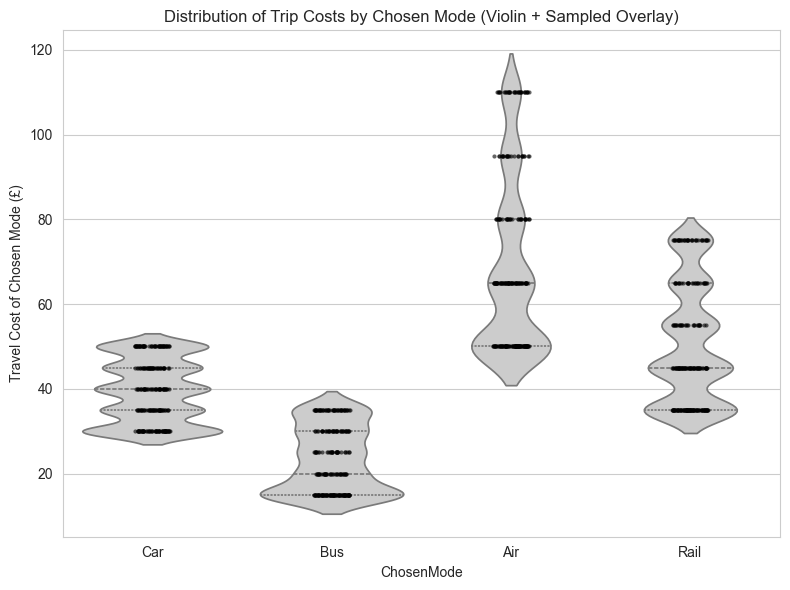

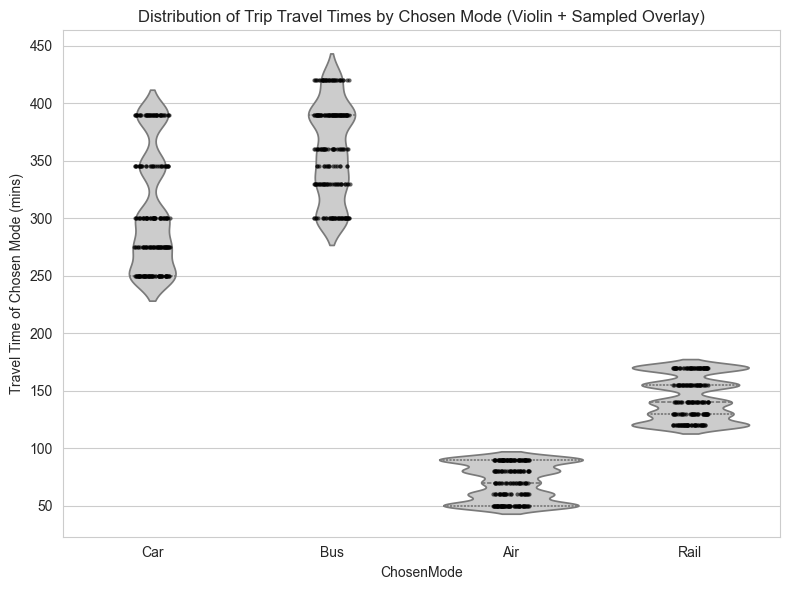

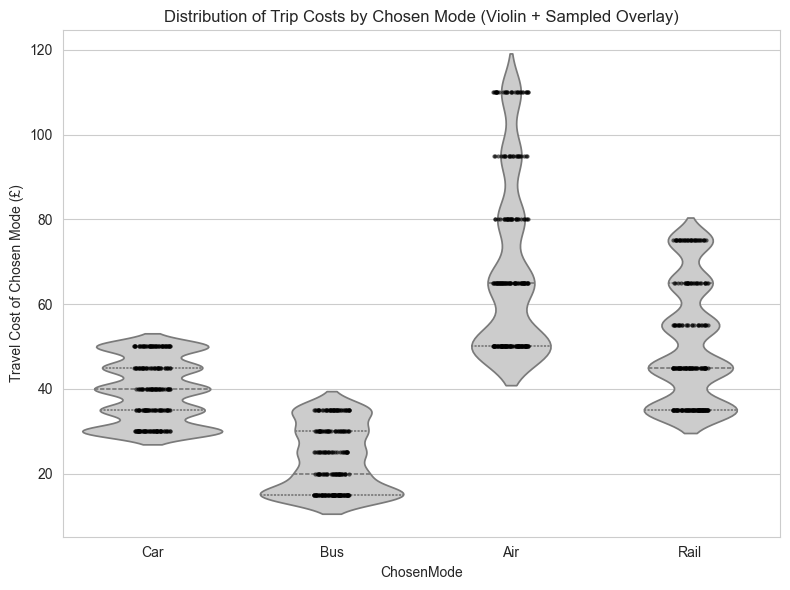

In [15]:
import numpy as np

def plot_violin_with_sampled_overlay(
    df, choice_col, value_cols, mode_labels, ylabel, title, overlay_sample=200, seed=0
):
    frames = []
    for mode_val, mode_name in zip(range(1, len(mode_labels) + 1), mode_labels):
        s = df.loc[df[choice_col] == mode_val, value_cols[mode_name]].dropna()
        if s.empty:
            continue
        frames.append(pd.DataFrame({"ChosenMode": mode_name, "Value": s}))
    if not frames:
        print("No data to plot.")
        return
    plot_df = pd.concat(frames, ignore_index=True)

    plt.figure(figsize=(8, 6))
    sns.violinplot(x="ChosenMode", y="Value", data=plot_df, inner="quartile", color=".8")
    
    rng = np.random.default_rng(seed)
    for mode_name in mode_labels:
        grp = plot_df[plot_df["ChosenMode"] == mode_name]
        if grp.empty:
            continue
        n = len(grp)
        if n <= overlay_sample:
            sns.swarmplot(x="ChosenMode", y="Value", data=grp, size=3, color="k", zorder=10)
        else:
            sampled = grp.sample(n=min(overlay_sample, n), random_state=seed)
            sns.stripplot(
                x="ChosenMode",
                y="Value",
                data=sampled,
                jitter=True,
                size=3,
                color="k",
                alpha=0.6,
                zorder=10,
            )

    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_violin_with_sampled_overlay(
    df, "choice", time_cols, mode_labels,
    "Travel Time of Chosen Mode (mins)",
    "Distribution of Trip Travel Times by Chosen Mode (Violin + Sampled Overlay)",
    overlay_sample=250, seed=1
)

plot_violin_with_sampled_overlay(
    df, "choice", cost_cols, mode_labels,
    "Travel Cost of Chosen Mode (£)",
    "Distribution of Trip Costs by Chosen Mode (Violin + Sampled Overlay)",
    overlay_sample=250, seed=1
)

def plot_violin_with_sampled_overlay(
    df, choice_col, value_cols, mode_labels, ylabel, title, overlay_sample=200, seed=0
):
    """
    Draw violin plots for each mode and overlay a sampled strip/swarm to show points.
    - Uses swarmplot only for small groups; for large groups it uses a sampled stripplot with jitter.
    - overlay_sample: max points per group to plot on top (keeps plotting fast and avoids swarm warnings).
    """
    frames = []
    for mode_val, mode_name in zip(range(1, len(mode_labels) + 1), mode_labels):
        s = df.loc[df[choice_col] == mode_val, value_cols[mode_name]].dropna()
        if s.empty:
            continue
        frames.append(pd.DataFrame({"ChosenMode": mode_name, "Value": s}))
    if not frames:
        print("No data to plot.")
        return
    plot_df = pd.concat(frames, ignore_index=True)

    plt.figure(figsize=(8, 6))
    sns.violinplot(x="ChosenMode", y="Value", data=plot_df, inner="quartile", color=".8")

    rng = np.random.default_rng(seed)
    for mode_name in mode_labels:
        grp = plot_df[plot_df["ChosenMode"] == mode_name]
        if grp.empty:
            continue
        n = len(grp)
        if n <= overlay_sample:
            sns.swarmplot(x="ChosenMode", y="Value", data=grp, size=3, color="k", zorder=10)
        else:
            sampled = grp.sample(n=min(overlay_sample, n), random_state=seed)
            sns.stripplot(
                x="ChosenMode",
                y="Value",
                data=sampled,
                jitter=True,
                size=3,
                color="k",
                alpha=0.6,
                zorder=10,
            )

    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_violin_with_sampled_overlay(
    df, "choice", time_cols, mode_labels,
    "Travel Time of Chosen Mode (mins)",
    "Distribution of Trip Travel Times by Chosen Mode (Violin + Sampled Overlay)",
    overlay_sample=250, seed=1
)

plot_violin_with_sampled_overlay(
    df, "choice", cost_cols, mode_labels,
    "Travel Cost of Chosen Mode (£)",
    "Distribution of Trip Costs by Chosen Mode (Violin + Sampled Overlay)",
    overlay_sample=250, seed=1
)


In the upcoming **Notebook 04**, we will build a simple Multinomial Logit model from scratch using one of the Apollo datasets (Swiss route choice), to estimate parameters like those $\beta_{time}$ and $\beta_{cost}$ that we informally discussed. We will apply our understanding of Python and data to actually perform model calculations and interpret outputs such as the value of time and model fit statistics.